# A pragmatic approach to pooling of samples for COVID-19 screening

The transverse pooling approach is based on the method described in the following paper:

Barillot, E., Lacroix, B., and Cohen, D. (1991) Theoretical analysis of library screening using a N-dimensional pooling strategy. Nucleic Acids Res., 19(22), 6241-6247.

A further description of the methodology (with open access) may be found in the conference paper:
Græsbøll, Kaare & Andresen, Lars Ole & Halasa, T. & Toft, Nils. (2016). How few pooled tests are needed to detect a single positive sample?https://www.researchgate.net/publication/299468021_How_few_pooled_tests_are_needed_to_detect_a_single_positive_sample

### Methodology

In the simple pooling approach samples are pooled. If the pool is isentified as containing a positive sample, all samples in the pool are tested.

In the transversal pooling approach, samples are arranged in a 12x8 matrix. This matrix is chosen to make it easily compatible with automation designed around 96 well plates. Samples in each of the 12 columns are pooled into 12 samples, and samples in each of the 8 rows are pooled into 8 samples. Each sample is therefore in 2 pools: one by row and the other by column. The pools are tested for the presence of COVID-19 The intersection of positive pools give the possible positive samples. When only a single sample is positive the two positive pools provide the row and column index of that positive sample, and no further screening is necessary. When more than one sample is positive, further screening is needed of all samples at the intersections of positive row and column pools (see figure). For example, if four samples are positive up to 16 samples will be re-screened (if no positive samples share row or column indices).

![](./images/transverse_method.png)

We compared the *transversal* approaches to a simple pooling method, where samples are pooled into groups of *k*, and then any pool with a positive result has all individuals assayed independently.

### Conclusions from modelling

A simple pooling approach is most efficient up to a 1% positive rate in samples. Above 1% sample positive rate, a transversal design becomes a little more efficient. Pooling can give about 3-8 fold increase in screening capacity whn screening samples with a 0.3% to 3% COVID positive rate.

## Import modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

## Set up model parameters

In [2]:
# Range of positive rates to test
positive_rates = [0.0001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]

# Pool sizes when simple pooling is used
simple_pool_sizes = [5, 10, 15, 20]

# Format for transverse pooling
transverse_columns = 12
transverse_rows = 8

# Number of samples to test in a simulation run
run_samples = 10000

# Number of repeatds
repeats = 100

## Function to randomly infect samples

Note: We assume random spread of positive samples. This is a simplification of the real world where clusters may exist if samples from the same location are grouped together.

In [3]:
def randomly_infect_samples(number_of_samples, p, seed = -1):    
    """
    Given size and probability, produce array of 0 and 1 with probability of p
    
    number_of_samples:
        an integer containing the number of samples
    p: 
        probability of each sample being infected (1)
    seed: 
        random seed to create the samples. If -1 then use a random number
    
    Returns positives: an array of 0 and 1 with probability of p, and each 
    dimension of size.
    """

    if seed != -1:
        # use a fixed sequence of random numbers as the seed to create a fixed 
        # set of samples for all pooling methods.
        np.random.seed(seed)

    samples = np.random.binomial(1, p, number_of_samples)
    
    return samples

## Simple pooling approach

In the simple pooling approach samples are pooled. If the pool is isentified as containing a positive sample, all samples in the pool are tested.

In [4]:
# Set up lists for results
results_replicate_number = []
results_pool_size = []
results_given_positive_rate = []
results_observed_positive_rate = []
results_frac_assay_used = []

# Loop through repeats
for replicate in range(repeats):
    print (replicate + 1, end =' ')
    # Loop through increasing sample positive rates
    for positive_rate in positive_rates:
        # Loop through pooling sizes
        for pool_size in simple_pool_sizes:
            # Calculate number of pools needed to be tested
            number_of_pools = int(run_samples / pool_size)
            # Set up counters for single run of all samples
            sample_count = 0; assay_count = 0; positives_count = 0
            # Loop through all pools
            for pool in range(number_of_pools):
                # Randomly infect samples
                samples = randomly_infect_samples(pool_size, positive_rate)
                # Count samples and number of positives
                sample_count += pool_size
                positives_count += np.sum(samples)
                # Total assays used = pool + all samples if one sample positive
                assay_count += (1 + np.max(samples) * pool_size)
            # Calculate observed positive rate    
            observed_positive_rate = positives_count / sample_count
            # Calculate assays/samples
            frac_assays_used = assay_count / sample_count
            # Store results for assay run
            results_replicate_number.append(replicate)
            results_pool_size.append(pool_size)
            results_given_positive_rate.append(positive_rate)
            results_observed_positive_rate.append(observed_positive_rate)
            results_frac_assay_used.append(frac_assays_used)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

Put results in DataFrame.

In [5]:
simple_pool_results = pd.DataFrame()
simple_pool_results['replication'] = results_replicate_number
simple_pool_results['pool size'] = results_pool_size
simple_pool_results['given positive rate'] = results_given_positive_rate
simple_pool_results['observed positive rate'] = results_observed_positive_rate
simple_pool_results['frac assays used'] = results_frac_assay_used

Get mean and standard deviation of replicates.

In [6]:
simple_pool_pivot_mean = simple_pool_results.groupby(
    ['pool size', 'given positive rate']).mean()['frac assays used']
simple_pool_pivot_std = simple_pool_results.groupby(
    ['pool size', 'given positive rate']).std()['frac assays used']

Create summary table of mean, standard deviation and sem.

In [7]:
simple_pool_pivot = pd.DataFrame()
simple_pool_pivot['mean'] = simple_pool_pivot_mean
simple_pool_pivot['std'] = simple_pool_pivot_std
simple_pool_pivot['sem'] = simple_pool_pivot_std / np.sqrt(repeats)
simple_pool_pivot['sem/mean'] = \
    simple_pool_pivot['sem'] / simple_pool_pivot['mean'] 

In [8]:
simple_pool_pivot

mean       std       sem  sem/mean
pool size given positive rate                                        
5         0.0001               0.200525  0.000463  0.000046  0.000231
          0.0030               0.214830  0.002832  0.000283  0.001318
          0.0100               0.248220  0.004532  0.000453  0.001826
          0.0300               0.341020  0.008315  0.000832  0.002438
          0.1000               0.608350  0.012216  0.001222  0.002008
          0.3000               1.032125  0.008696  0.000870  0.000843
          1.0000               1.200000  0.000000  0.000000  0.000000
10        0.0001               0.101000  0.000943  0.000094  0.000933
          0.0030               0.129750  0.005392  0.000539  0.004156
          0.0100               0.194420  0.009565  0.000957  0.004920
          0.0300               0.361520  0.015418  0.001542  0.004265
          0.1000               0.752280  0.013778  0.001378  0.001832
          0.3000               1.071340  0.005535  0.000553  0.000517
          1.0000               1.100000  0.000000  0.000000  0.000000
15        0.0001               0.068228  0.001679  0.000168  0.002461
          0.0030               0.111607  0.008460  0.000846  0.007580
          0.0100               0.207447  0.013692  0.001369  0.006600
          0.0300               0.434039  0.017215  0.001722  0.003966
          0.1000               0.857928  0.016654  0.001665  0.001941
          0.3000               1.061502  0.002501  0.000250  0.000236
          1.0000               1.066667  0.000000  0.000000  0.000000
20        0.0001               0.051780  0.001796  0.000180  0.003468
          0.0030               0.106340  0.011094  0.001109  0.010433
          0.0100               0.230900  0.016373  0.001637  0.007091
          0.0300               0.511060  0.023389  0.002339  0.004576
          0.1000               0.929280  0.013395  0.001340  0.001441
          0.3000               1.049440  0.001028  0.000103  0.000098
          1.0000               1.050000  0.000000  0.000000  0.000000

Plot results.

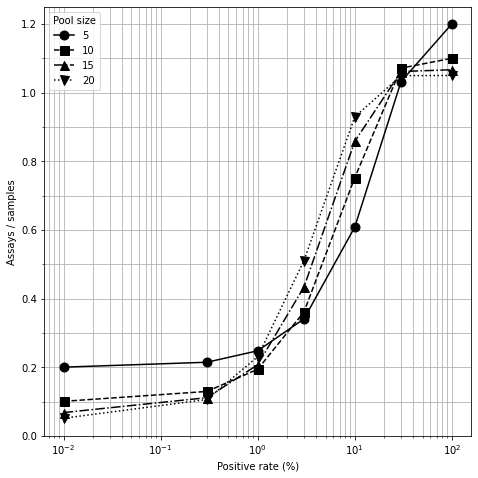

In [9]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
symbol = ['o', 's', '^', 'v']
linestyle = ['-', '--', '-.', ':']

for i in range(4):
    pool_size = simple_pool_sizes[i]
    x = [x * 100 for x in positive_rates]
    y = simple_pool_pivot.loc[pool_size]['mean']
    ax.plot(x, y, 
            linestyle =linestyle[i],
            marker=symbol[i],
            color='k',
            markersize=9,
            label=pool_size)
    y_err = simple_pool_pivot.loc[pool_size]['sem']
    ax.errorbar(x, y, yerr = y_err, fmt = 'none')
ax.set_ylim(0, 1.25)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.grid(True, which='both')
ax.set_xlabel('Positive rate (%)')
ax.set_ylabel('Assays / samples')
ax.set_xscale('log')

plt.legend(title='Pool size')
plt.tight_layout(pad=2)
plt.savefig('./simple_pooling.png', dpi=300, facecolor='w')
plt.show()      

## Transverse pooling

In [10]:
# Set up lists for results
results_replicate_number = []
results_pool_size = []
results_given_positive_rate = []
results_observed_positive_rate = []
results_frac_assay_used = []

# Calculate pool size and number of pools needed to be tested
pool_size = transverse_columns * transverse_rows
number_of_pools = int(run_samples / pool_size)

# Loop through repeats
for replicate in range(repeats):
    print (replicate + 1, end =' ')
    # Loop through increasing sample positive rates
    for positive_rate in positive_rates:
        # Set up counters for single run of all samples
        sample_count = 0; assay_count = 0; positives_count = 0
        # Loop through all pools
        for pool in range(number_of_pools):
            # Randomly infect samples
            samples = randomly_infect_samples(pool_size, positive_rate)
            # Count samples and number of positives
            sample_count += pool_size
            positives_count += np.sum(samples)
            # Reshape samples into 12 x 8 matrix
            samples = samples.reshape(transverse_rows, transverse_columns)
            # Get number of positve columns and rows
            positive_columns = np.sum(samples.sum(axis=0) > 0)
            positive_rows = np.sum(samples.sum(axis=1) > 0)
            # Count assays needed for inital matrix
            assay_count += transverse_columns + transverse_rows
            # Add follow-on screening (if 2+ columns and 2+ rows are positive)
            if positive_columns > 1 and positive_rows > 1:
                # Multiple +ve rows and columns. Follow-on screen needed
                intersections = positive_columns * positive_rows
                assay_count += intersections
        # Calculate observed positive rate
        observed_positive_rate = positives_count / sample_count
        # Calculate assays/samples
        frac_assays_used = assay_count / sample_count
        # Store results for assay run
        results_replicate_number.append(replicate)
        results_given_positive_rate.append(positive_rate)
        results_observed_positive_rate.append(observed_positive_rate)
        results_frac_assay_used.append(frac_assays_used) 

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

Put results in DataFrame.

In [11]:
transverse_pool_results = pd.DataFrame()
transverse_pool_results['replication'] = results_replicate_number
transverse_pool_results['given positive rate'] = results_given_positive_rate
transverse_pool_results['observed positive rate'] = results_observed_positive_rate
transverse_pool_results['frac assays used'] = results_frac_assay_used

Get mean and standard deviation of replicates.

In [12]:
transverse_pool_pivot_mean = transverse_pool_results.groupby(
    ['given positive rate']).mean()['frac assays used']
transverse_pool_pivot_std = transverse_pool_results.groupby(
    ['given positive rate']).std()['frac assays used']

Create summary table of mean, standard deviation and sem.

In [13]:
transverse_pool_pivot = pd.DataFrame()
transverse_pool_pivot['mean'] = transverse_pool_pivot_mean
transverse_pool_pivot['std'] = transverse_pool_pivot_std
transverse_pool_pivot['sem'] = transverse_pool_pivot_std / np.sqrt(repeats)
transverse_pool_pivot['sem/mean'] = \
    transverse_pool_pivot['sem'] / transverse_pool_pivot['mean'] 

In [14]:
transverse_pool_pivot

,mean,std,sem,sem/mean
given positive rate,,,,
0.0001,0.208333,0.000000,0.000000,0.000000
0.0030,0.209682,0.000783,0.000078,0.000374
0.0100,0.220846,0.002894,0.000289,0.001310
0.0300,0.288214,0.008402,0.000840,0.002915
0.1000,0.630221,0.015796,0.001580,0.002506
0.3000,1.137974,0.007769,0.000777,0.000683
1.0000,1.208333,0.000000,0.000000,0.000000


Plot results (compare with simple pools of 10 samples).

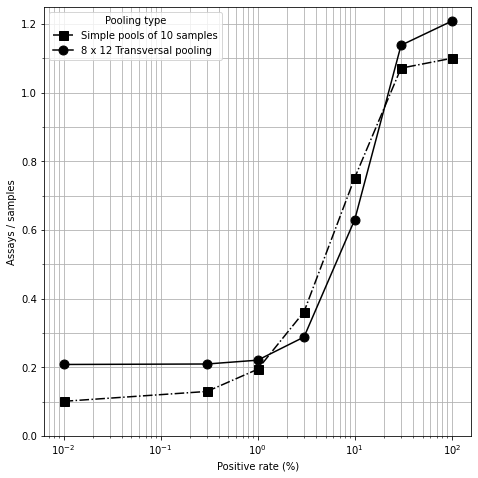

In [15]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)


x = [x * 100 for x in positive_rates]
y1 = simple_pool_pivot.loc[10]['mean']
ax.plot(x, y1, linestyle='-.', marker='s', color='k', markersize=9,
        label='Simple pools of 10 samples')
y1_err = simple_pool_pivot.loc[10]['sem']
ax.errorbar(x, y1, yerr = y1_err, fmt = 'none', color='k')


y2 = transverse_pool_pivot['mean']
ax.plot(x, y2, linestyle='-', marker='o', color='k', markersize=9,
    label='8 x 12 Transversal pooling')
y2_err = transverse_pool_pivot['sem']
ax.errorbar(x, y2, yerr = y2_err, fmt = 'none', color='k')

    
ax.set_ylim(0, 1.25)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.grid(True, which='both')
ax.set_xlabel('Positive rate (%)')
ax.set_ylabel('Assays / samples')
ax.set_xscale('log')

plt.legend(title='Pooling type')
plt.tight_layout(pad=2)
plt.savefig('./simple_vs_transversal_pooling.png', dpi=300, facecolor='w')
plt.show()     

Tabular comparison of 12 x 8 transverse pooling vs. simple pool of 10 samples.

In [18]:
comparison = pd.DataFrame()
comparison['simple pool 10'] = simple_pool_pivot.loc[10]['mean']
comparison['12 x 8 transverse pooling'] = transverse_pool_pivot['mean']
comparison['transverse/simple'] = (comparison['12 x 8 transverse pooling'] /
                                   comparison['simple pool 10'])
comparison

,simple pool 10,12 x 8 transverse pooling,transverse/simple
given positive rate,,,
0.0001,0.10100,0.208333,2.062706
0.0030,0.12975,0.209682,1.616050
0.0100,0.19442,0.220846,1.135924
0.0300,0.36152,0.288214,0.797229
0.1000,0.75228,0.630221,0.837748
0.3000,1.07134,1.137974,1.062197
1.0000,1.10000,1.208333,1.098485
